## Objective

**Cryptocurrency prediction experiment** to predict direction of the close price of BTCUSDT for the next 10 hours

Dataset:
- BTCUSDT 1h in Json format from Binance

Prediction target logic:
- Set treshold to +-1%
- If next 10 hours close price is higher than 1% of current close price, label as 1
- If next 10 hours close price is lower than -1% of current close price, label as -1
- Else label as 0

Since we focus on the direction of the price, we will use classification model for this experiment

In [7]:
import pandas as pd

# Ref from data exploration
def remove_outlier(df, iqr_threshold = 5):
    
    # Calculate the first quartile (25th percentile) and third quartile (75th percentile)
    q1 = df['volume'].quantile(0.25)
    q3 = df['volume'].quantile(0.75)

    # Calculate the interquartile range (IQR)
    iqr = q3 - q1

    # Define lower and upper bounds for outliers
    lower_bound = q1 - iqr_threshold * iqr
    upper_bound = q3 + iqr_threshold * iqr

    lower_bound = 0 if lower_bound < 0 else lower_bound

    # remove outliers from df
    df = df[(df['volume'] > lower_bound) & (df['volume'] < upper_bound)]
    
    return df

def read_hist_data(name = 'BTC', timeframe = '1h'):
    file_path = f"./data/{name}_USDT-{timeframe}.json"
    df = pd.read_json(file_path)

    # set column names
    df.columns = ['datetime', 'open', 'high', 'low', 'close', 'volume']

    # convert unix timestamp to datetime
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    
    df = remove_outlier(df)
    return df



## Feature Engineering

In [8]:
df = read_hist_data(name = 'BTC', timeframe = '1h') # read data
# df = read_hist_data(name = 'BTC', timeframe = '5m') # read data
print(df.head(10))
print(df.tail(10)) 

df.describe()

             datetime      open      high       low     close       volume
0 2021-01-01 00:00:00  28923.63  29031.34  28690.17  28995.13  2311.811445
1 2021-01-01 01:00:00  28995.13  29470.00  28960.35  29409.99  5403.068471
2 2021-01-01 02:00:00  29410.00  29465.26  29120.03  29194.65  2384.231560
3 2021-01-01 03:00:00  29195.25  29367.00  29150.02  29278.40  1461.345077
4 2021-01-01 04:00:00  29278.41  29395.00  29029.40  29220.31  2038.046803
5 2021-01-01 05:00:00  29220.31  29235.28  29084.11  29187.01  1469.956262
6 2021-01-01 06:00:00  29187.01  29270.00  29077.32  29174.35  1420.726291
7 2021-01-01 07:00:00  29174.35  29191.98  28806.54  29092.83  2380.180918
8 2021-01-01 08:00:00  29092.84  29178.03  28872.24  29000.01  2008.165739
9 2021-01-01 09:00:00  29000.01  29307.73  28970.00  29202.21  2022.056022
                 datetime      open      high       low     close      volume
23121 2023-08-22 23:00:00  25808.00  26070.04  25784.69  26056.00  2291.04723
23122 2023-08-23 00

,datetime,open,high,low,close,volume
count,22915,22915.000000,22915.000000,22915.000000,22915.000000,22915.000000
mean,2022-04-26 04:37:59.869081600,35117.336473,35297.705123,34928.163154,35117.620848,4477.749672
min,2021-01-01 00:00:00,15648.230000,15769.990000,15476.000000,15649.520000,5.887034
25%,2021-08-28 09:30:00,23415.510000,23483.855000,23341.975000,23414.470000,1398.628235
50%,2022-04-24 06:00:00,32099.970000,32345.000000,31800.000000,32099.980000,2658.617538
75%,2022-12-22 12:30:00,45197.645000,45485.530000,44869.145000,45197.975000,5828.032940
max,2023-08-23 08:00:00,68635.120000,69000.000000,68451.190000,68633.690000,28721.893750
std,NaN,13125.131469,13210.580569,13033.198250,13125.379765,4697.700455


Use TAlib (Technical Analysis Library) in Python to create technical indicators that might have prediction power.
- We will explore all available data whixh is Open, High, Low, Close, Volume
- We will focus in index type indicators since it's more generalizable to other stocks

In [9]:
import talib
import numpy as np
import warnings



def get_features(df):
    # df = read_hist_data()

    # List of periods
    periods = [4, 12, 24, 48, 100, 200]
    # periods = [4]
    inputs = ['high', 'low', 'close', 'volume']
    # inputs = ['high', 'low', 'close']

    
    # loop periods and inputs
    for period in periods:
        for input in inputs:
            # Generate indicators

            # % of ema
            pct_ema = talib.EMA(df[input].values, timeperiod=period)
            df[f'{input}_ema_{period}'] = (df[input] - pct_ema) / pct_ema * 100

            # RSI
            df[f'{input}_rsi_{period}'] = talib.RSI(df[input].values, timeperiod=period)

            # TRIX
            # df[f'{input}_trix_{period}'] = talib.TRIX(df[input].values, timeperiod=period)

            # SD
            pct_sd = talib.STDDEV(df[input].values, timeperiod=period)
            df[f'{input}_sd_{period}'] = pct_sd / df[input] * 100

            # ROC
            df[f'{input}_roc_{period}'] = talib.ROC(df[input].values, timeperiod=period)

            # VAR
            df[f'{input}_var_{period}'] = talib.VAR(df[input].values, timeperiod=period)

        
        # Multiple inputs indicators
        # ATR
        pct_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
        df[f'price_atr_{period}'] = pct_atr / df['close'] * 100

        # Price interaction Features:
        df[f'price_interact_{period}'] = df[f'close_roc_{period}'] * df[f'price_atr_{period}']

        # Price volume interaction:
        df[f'pv_interact_{period}'] = df[f'close_roc_{period}'] * df[f'volume_roc_{period}']

        # ADX
        df[f'price_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

        # MFI
        df[f'mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

        # DX
        df[f'price_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

    return df

# to predict if the price will go up (+1%) or down (-1%) in the next 10 periods
def get_target_next_close(df, target_shift = 10):
    # df = get_features()

    target_treshold = 0.01
    conditions = [
        (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
        (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
        (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
        (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
    ]
    values = [1, -1, 0]
    df['target'] = np.select(conditions, values)
    df = df.dropna()
    return df

def get_features_target_next_close():

    # Disable the PerformanceWarning temporarily
    warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

    df = read_hist_data()
    df = get_features(df)
    df = get_target_next_close(df)

    # Re-enable warnings
    warnings.resetwarnings()

    return df

df = get_features_target_next_close()

print(df.head(5))
print(df.tail(5))



               datetime      open      high       low     close       volume  \
399 2021-01-17 15:00:00  34750.02  35973.89  34750.01  35728.47  4341.235449   
400 2021-01-17 16:00:00  35728.47  36166.47  35589.35  35910.07  3578.888951   
401 2021-01-17 17:00:00  35914.98  36123.14  35603.01  35837.22  2191.923305   
402 2021-01-17 18:00:00  35837.22  35920.63  35625.40  35678.67  1484.556842   
403 2021-01-17 19:00:00  35676.58  36000.00  35514.99  35633.91  2043.037186   

     high_ema_4  high_rsi_4  high_sd_4  high_roc_4  ...  volume_sd_200  \
399    1.025822   70.064212   0.728964    1.621158  ...      78.257525   
400    0.934134   74.858358   1.015086    1.747430  ...      94.888646   
401    0.486343   71.426750   1.031088    1.755324  ...     155.155972   
402   -0.046211   55.556357   0.283157    1.920886  ...     229.558210   
403    0.104715   60.179927   0.271190    0.072580  ...     167.154918   

     volume_roc_200  volume_var_200  price_atr_200  price_interact_200  \


In [10]:
# total columns
print(f'Total columns: {len(df.columns)}')

# list(df.columns)

Total columns: 163


##### Identify the most important features

When dealing with a large number of features, it's crucial to determine which features are most relevant for predicting your target variable. Feature selection techniques can help you identify the most relevant features, reduce overfitting, improve accuracy, and reduce training time.

We will use a **Tree-Based Model** to rank the importance of each feature.

In [11]:
from sklearn.model_selection import train_test_split

drop_cols = ['datetime', 'open', 'high', 'low', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [12]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=50, random_state=55, n_jobs=-1) # n_jobs=-1 to use all cores
model.fit(X_train, y_train)

importances = model.feature_importances_


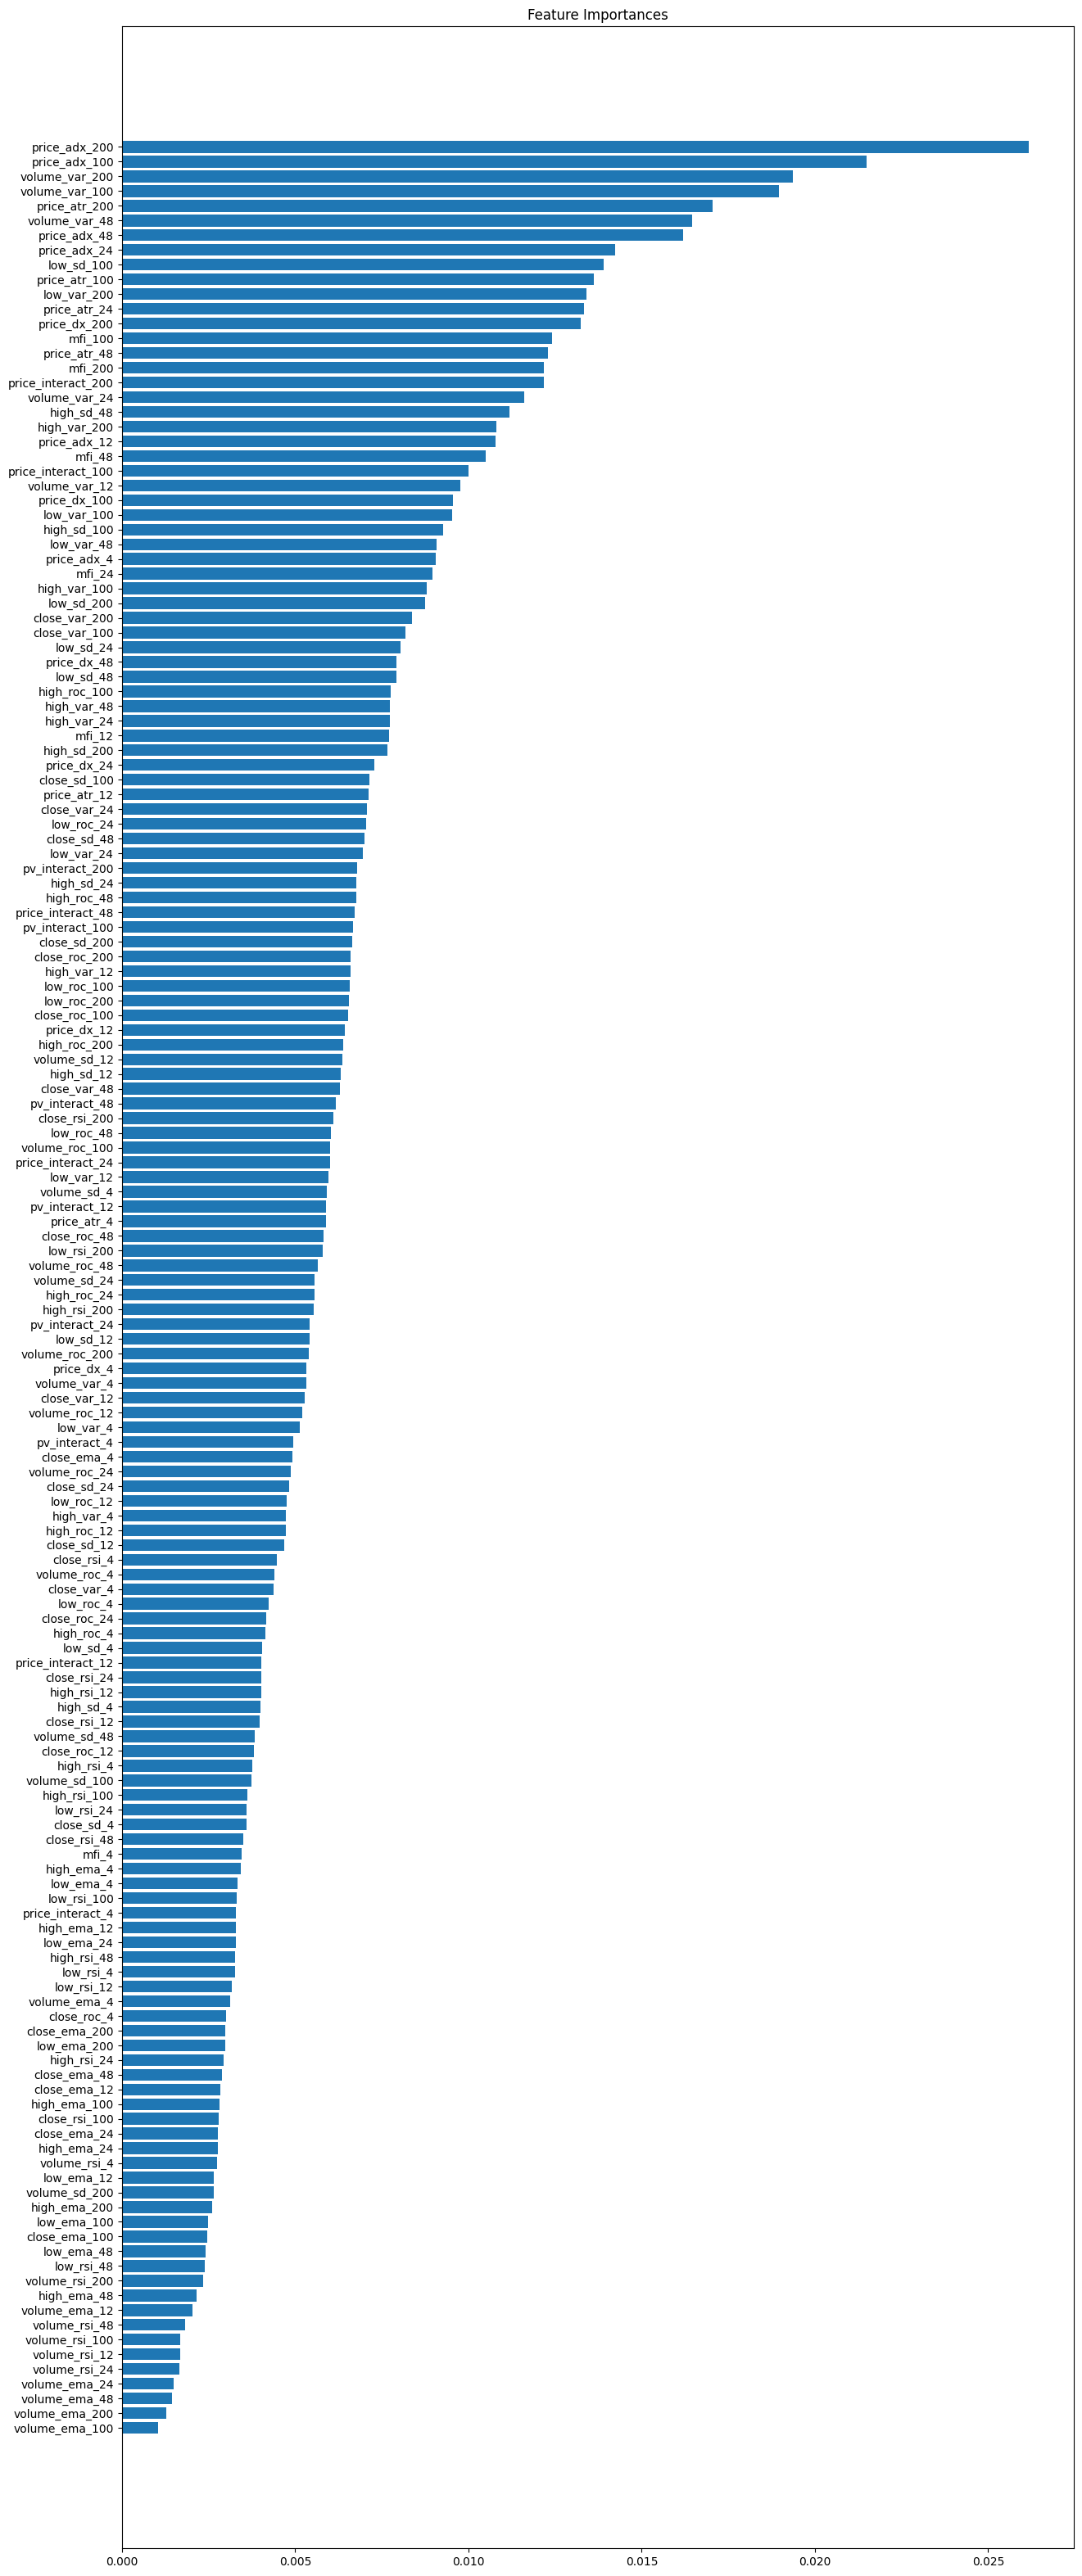

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(15, 40))
plt.title("Feature Importances")
plt.barh(range(X.shape[1]), importances[indices], align="center")
plt.yticks(range(X.shape[1]), [feature_names[i] for i in indices])
plt.gca().invert_yaxis()
plt.show()


The plot should give us a good indication of which features may be irrelevant and can be removed from the data.
- ADX (Momemtum), VAR (Risk) , ATR (Volatility) are the most important features
- EMA (Momemtum) and RSI (Momemtum) have much less prediction power

----

### Experiment 1: Baseline

We will use all data we have to train multiple models and see which one performs better. We'll use the best one as our baseline.

In [20]:
df = get_features_target_next_close()

In [21]:
from sklearn.model_selection import train_test_split

# Splitting the data
drop_cols = ['datetime', 'high', 'low', 'open', 'close', 'volume', 'target']
X = df.drop(drop_cols, axis=1)
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=55)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# import warnings
from sklearn.exceptions import ConvergenceWarning

# Suppress ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

random_state = 55

# Define models
models = [
    ('LogisticRegression', LogisticRegression(random_state=random_state, solver='lbfgs', max_iter=100000, n_jobs=-1)),
    ('SGD', SGDClassifier(random_state=random_state, max_iter=10000, tol=1e-3, n_jobs=-1)),
    ('SVM', SVC(kernel='linear', random_state=random_state, max_iter=100000)),
    ('NaiveBayes', GaussianNB()),
    ('DecisionTree', DecisionTreeClassifier(random_state=random_state))
]

# Test each model
for name, model in models:
    pipeline = Pipeline([
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy')
    # print(scores)
    print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")

# Re-enable warnings
warnings.resetwarnings()

LogisticRegression: Mean Accuracy: 0.54, Standard Deviation: 0.01
SGD: Mean Accuracy: 0.38, Standard Deviation: 0.12
SVM: Mean Accuracy: 0.29, Standard Deviation: 0.06
NaiveBayes: Mean Accuracy: 0.53, Standard Deviation: 0.00
DecisionTree: Mean Accuracy: 0.63, Standard Deviation: 0.01


In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Using bagging with decision trees as the base classifier
bagging_clf = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=55)
bagging_clf.fit(X_train, y_train)

# Making predictions
y_pred = bagging_clf.predict(X_test)



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Bagging Classifier: {accuracy:.2f}")

Accuracy of the Bagging Classifier: 0.77


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['-1', '0', '+1'], 
            yticklabels=['-1', '0', '+1'])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 2. Feature Importance
# Since our base estimator is a decision tree, we can obtain feature importances.
# We average feature importance over all the base estimators to get an average importance.

# Collecting importances from each tree
importances = np.array([tree.feature_importances_ for tree in bagging_clf.estimators_])

# Averaging over trees
avg_importance = importances.mean(axis=0)

plt.figure(figsize=(30, 6))
sns.barplot(x=X.columns, y=avg_importance)
plt.title('Feature Importance')
plt.xticks(rotation=90)
plt.show()

# 3. ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_pred)

# Calculate roc curves
fpr, tpr, _ = roc_curve(y_test, y_pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='red', label=f'ROC curve (area = {roc_value:.2f})')
plt.plot([0, 1], [0, 1], color='blue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


NameError: name 'y_test' is not defined

----
## Note:

In [ ]:
# select only features with importance > 0.01
selected_features = X_train.columns[(importances > np.mean(importances))]
# selected_features = X_train.columns[(importances > 0.005)]
print(len(selected_features))
print(selected_features)

In [ ]:
# import talib
# import numpy as np

# def get_features():
#     # df = pd.read_csv('./data/BTCUSDT_1h.csv') 
#     df = read_hist_data()

    

#     # List of periods
#     periods = [4, 12, 24, 48, 100, 200]

#     # loop through periods
#     for period in periods:

#         # Price indicators
#         # price % of ema
#         p_ema = talib.EMA(df['close'].values, timeperiod=period)
#         df[f'p_ema_{period}'] = (df['close'] - p_ema) / p_ema * 100

#         # RSI
#         df[f'p_rsi_{period}'] = talib.RSI(df['close'].values, timeperiod=period)

#         # TRIX
#         df[f'p_trix_{period}'] = talib.TRIX(df['close'].values, timeperiod=period)

#         # SD
#         p_sd = talib.STDDEV(df['close'].values, timeperiod=period)
#         df[f'p_sd_{period}'] = p_sd / df['close'] * 100

#         # ATR
#         p_atr = talib.ATR(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)
#         df[f'p_atr_{period}'] = p_atr / df['close'] * 100

#         # ROC
#         df[f'p_roc_{period}'] = talib.ROC(df['close'].values, timeperiod=period)

#         # Interaction Features:
#         df[f'p_interaction_{period}'] = df[f'p_roc_{period}'] * df[f'p_atr_{period}']


#         # Volume indicators
#         v_ema = talib.EMA(df['volume'], timeperiod=period)

#         # volume % of ema
#         df[f'v_ema_{period}'] = (df['volume'] - v_ema) / v_ema * 100

#         # RSI
#         df[f'v_rsi_{period}'] = talib.RSI(df['volume'].values, timeperiod=period)

#         # ROC
#         df[f'v_roc_{period}'] = talib.ROC(df['volume'].values, timeperiod=period)

#         # price volume interaction
#         df[f'pv_interaction_{period}'] = df[f'p_roc_{period}'] * df[f'v_roc_{period}']

#         # ==================== #

#         # ADX
#         df[f'p_adx_{period}'] = talib.ADX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

#         # # CCI
#         # df[f'p_cci_{period}'] = talib.CCI(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

#         # MFI
#         # df[f'p_mfi_{period}'] = talib.MFI(df['high'].values, df['low'].values, df['close'].values, df['volume'].values, timeperiod=period)

#         # OBV
#         # obv = talib.OBV(df['close'].values, df['volume'].values)
#         # avg_obv = talib.EMA(obv, timeperiod=period)
#         # df[f'p_obv_ref_{period}'] = (obv - avg_obv) / avg_obv * 100

#         # DX
#         df[f'p_dx_{period}'] = talib.DX(df['high'].values, df['low'].values, df['close'].values, timeperiod=period)

#         # df[f'p_dm-_{period}'] = talib.MINUS_DM(df['high'].values, df['low'].values, timeperiod=period)
#         # df[f'p_dm+_{period}'] = talib.PLUS_DM(df['high'].values, df['low'].values, timeperiod=period)

#         # VAR
#         df[f'p_var_{period}'] = talib.VAR(df['close'].values, timeperiod=period)



#     return df

# def get_target_next_close(df, target_shift = 10):
#     target_treshold = 0.01
#     conditions = [
#         (df['close'].shift(target_shift * -1) > df['close'] * (1+target_treshold )),
#         (df['close'].shift(target_shift * -1) < df['close'] * (1-target_treshold)),
#         (df['close'].shift(target_shift * -1) >= df['close'] * (1-target_treshold)) & 
#         (df['close'].shift(target_shift * -1) <= df['close'] * (1+target_treshold))
#     ]
#     values = [1, -1, 0]
#     df['target'] = np.select(conditions, values)
#     df = df.dropna()
#     return df
    

# df = get_features()
# df = get_target_next_close(df)
# print(df.head(10))
# print(df.tail(10))

In [ ]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score
# from sklearn.linear_model import LogisticRegression
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.svm import SVC
# # from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
# from sklearn.tree import DecisionTreeClassifier

# # Initialize n_jobs option
# use_parallel = True  # Set to False if you don't want to use parallel processing
# random_state = 55

# # Define models
# models = [
#     ('LogisticRegression', LogisticRegression(random_state=random_state, max_iter=1000, n_jobs=-1 if use_parallel else None)),
#     ('KNN', KNeighborsClassifier(n_jobs=-1 if use_parallel else None)),
#     ('SVM', SVC(kernel='linear', random_state=random_state, max_iter=10000)),
#     # ('RandomForest', RandomForestClassifier(random_state=random_state, n_jobs=-1 if use_parallel else None)),
#     # ('ExtraTrees', ExtraTreesClassifier(random_state=random_state, n_jobs=-1 if use_parallel else None)),
#     # ('GradientBoosting', GradientBoostingClassifier(random_state=random_state)),
#     ('DecisionTree', DecisionTreeClassifier(random_state=random_state, n_jobs=-1 if use_parallel else None))
# ]

# # Test each model
# for name, model in models:
#     pipeline = Pipeline([
#         ('model', model)
#     ])
#     scores = cross_val_score(pipeline, X_train, y_train, scoring='accuracy')
#     print(scores)
#     print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")


In [ ]:

# # Pipelines to test multiple models
# models = [
#     ('DecisionTree', DecisionTreeClassifier(random_state=42)),
#     ('BaggingClassifier', BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)),
#     ('SVM', SVC(kernel='linear', random_state=42, max_iter=10000)),
#     ('LogisticRegression', LogisticRegression(random_state=42))
# ]

# for name, model in models:
#     pipeline = Pipeline([
#         ('model', model)
#     ])
#     scores = cross_val_score(pipeline, X_train_smote, y_train_smote, cv=cv, scoring='accuracy')
#     print(scores)
#     print(f"{name}: Mean Accuracy: {scores.mean():.2f}, Standard Deviation: {scores.std():.2f}")